# AC Time Series JEPA - Interactive Explore

Explore data, run training steps, and verify training works. Run cells in Jupyter or VS Code.

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.amp import GradScaler, autocast
from torch.optim import AdamW

# we use __file__ when run as script; in Jupyter __file__ is undefined so we infer from cwd
ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else (Path.cwd() if (Path.cwd() / "pyproject.toml").exists() else Path.cwd().parent)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
os.chdir(ROOT)

In [2]:
from eb_jepa.datasets.utils import init_data

loader, val_loader, data_config = init_data("hft_timeseries")
x, a, loc, _, _ = next(iter(loader))

print("Batch shapes: x", x.shape, "| a", a.shape, "| loc", loc.shape)
print("Batches:", len(loader), "| batch_size:", data_config.batch_size)

Batch shapes: x torch.Size([64, 17, 8, 1, 1]) | a torch.Size([64, 17, 1]) | loc torch.Size([64, 17, 8])
Batches: 140 | batch_size: 64


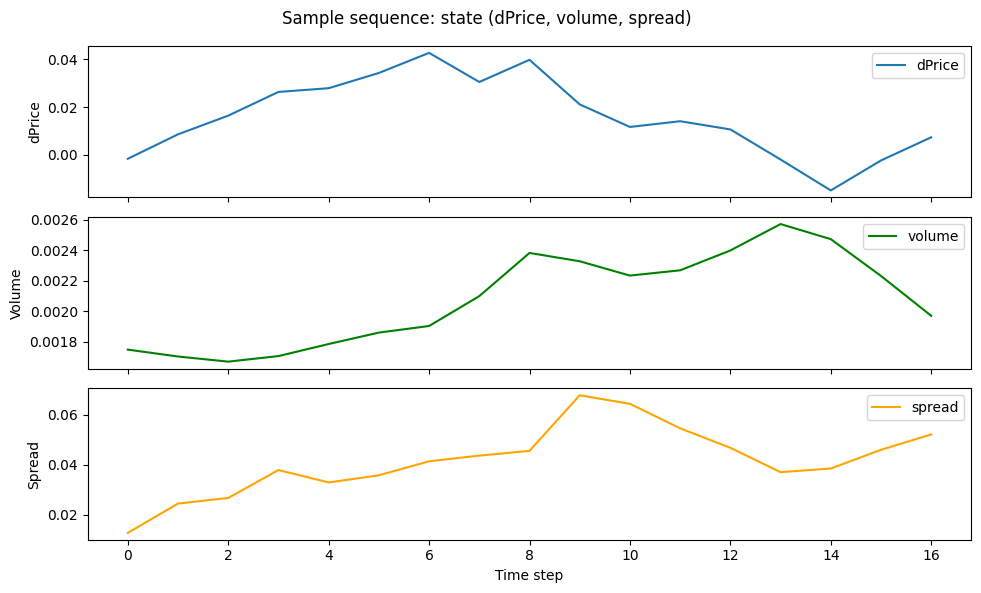

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
sample_idx = 0
t = torch.arange(loc.shape[1])
axes[0].plot(t, loc[sample_idx, :, 0].numpy(), label="dPrice")
axes[0].set_ylabel("dPrice")
axes[0].legend(loc="upper right")
axes[1].plot(t, loc[sample_idx, :, 1].numpy(), label="volume", color="green")
axes[1].set_ylabel("Volume")
axes[1].legend(loc="upper right")
axes[2].plot(t, loc[sample_idx, :, 2].numpy(), label="spread", color="orange")
axes[2].set_ylabel("Spread")
axes[2].set_xlabel("Time step")
axes[2].legend(loc="upper right")
plt.suptitle("Sample sequence: state (dPrice, volume, spread)")
plt.tight_layout()
out_dir = ROOT / "notebooks" / "outputs"
out_dir.mkdir(exist_ok=True)
plt.savefig(out_dir / "sample_sequence.png", dpi=100)
plt.show()

In [4]:
from eb_jepa.architectures import (
    InverseDynamicsModel,
    RNNPredictor,
    TimeSeriesEncoder,
)
from eb_jepa.jepa import JEPA, JEPAProbe
from eb_jepa.losses import CosineLossSeq, VC_IDM_Sim_Regularizer
from eb_jepa.state_decoder import MLPStateHead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ds = loader.dataset.dataset if hasattr(loader.dataset, "dataset") else loader.dataset
state_dim = getattr(data_config, "state_dim", ds.state_dim)
action_dim = 1
seq_len = getattr(data_config, "seq_len", ds.seq_len)
nsteps = 8

# we use use_final_ln=False for 2D viz: LayerNorm forces dim0+dim1=0 (y=-x), collapsing to 1D
encoder = TimeSeriesEncoder(input_dim=state_dim, hidden_dim=64, output_dim=2, use_final_ln=False)
test_out = encoder(torch.rand(1, state_dim, seq_len, 1, 1))
_, f, _, h, w = test_out.shape

# final_ln=Identity: LayerNorm on predictor forces zero-mean -> y=-x for 2D; remove it
predictor = RNNPredictor(
    hidden_size=encoder.mlp_output_dim,
    action_dim=action_dim,
    final_ln=nn.Identity(),
)
idm = InverseDynamicsModel(
    state_dim=h * w * f,
    hidden_dim=256,
    action_dim=action_dim,
).to(device)
# cov/std DECORRELATE embeddings; need them strong (cov penalizes off-diag correlation)
regularizer = VC_IDM_Sim_Regularizer(
    cov_coeff=8, std_coeff=8, sim_coeff_t=4, idm_coeff=0.5,
    idm=idm, first_t_only=False, projector=None,
    spatial_as_samples=False, idm_after_proj=False, sim_t_after_proj=False,
)
# pred_coeff>>1 so prediction drives learning; CosineLossSeq is scale-invariant for unbounded embeddings
predcost = CosineLossSeq()
jepa = JEPA(encoder, nn.Identity(), predictor, regularizer, predcost, pred_coeff=25.0).to(device)

state_head = MLPStateHead(
    input_dim=encoder.mlp_output_dim,
    output_dim=state_dim,
    normalizer=getattr(ds, "normalizer", None),
).to(device)
state_prober = JEPAProbe(jepa=jepa, head=state_head, hcost=nn.MSELoss())

jepa_opt = AdamW(jepa.parameters(), lr=1e-3, weight_decay=1e-6)
probe_opt = AdamW(state_head.parameters(), lr=1e-3, weight_decay=1e-5)
scaler = GradScaler(device.type, enabled=False)  # we disable amp to avoid float16 NaN
dtype = torch.float32

print("Model built. Encoder out dim:", encoder.mlp_output_dim)

Model built. Encoder out dim: 2


In [5]:
NUM_EPOCHS = 3
NUM_STEPS = len(loader) * NUM_EPOCHS
losses = []

for step, (x_b, a_b, loc_b, _, _) in enumerate(loader):
    if step >= NUM_STEPS:
        break
    x_b = x_b.permute(0, 2, 1, 3, 4).to(device)
    a_b = a_b.permute(0, 2, 1).to(device)
    loc_b = loc_b.permute(0, 2, 1).to(device)
    # we replace any nan/inf in batch to avoid training collapse
    x_b = torch.nan_to_num(x_b, nan=0.0, posinf=0.0, neginf=0.0)
    a_b = torch.nan_to_num(a_b, nan=0.0, posinf=0.0, neginf=0.0)
    loc_b = torch.nan_to_num(loc_b, nan=0.0, posinf=0.0, neginf=0.0)

    jepa_opt.zero_grad()
    with autocast(device.type, enabled=False, dtype=dtype):
        _, (jepa_loss, regl, _, _, pl) = jepa.unroll(
            x_b, a_b, nsteps=nsteps,
            unroll_mode="autoregressive", ctxt_window_time=1,
            compute_loss=True, return_all_steps=False,
        )
    scaler.scale(jepa_loss).backward()
    torch.nn.utils.clip_grad_norm_(jepa.parameters(), max_norm=1.0)
    scaler.step(jepa_opt)
    scaler.update()

    probe_opt.zero_grad()
    with autocast(device.type, enabled=False, dtype=dtype):
        probe_loss = state_prober(
            observations=x_b[:, :, :1],
            targets=loc_b[:, :, :1],
        )
    scaler.scale(probe_loss).backward()
    torch.nn.utils.clip_grad_norm_(state_head.parameters(), max_norm=1.0)
    scaler.step(probe_opt)
    scaler.update()

    total = jepa_loss.item() + probe_loss.item()
    losses.append({"total": total, "jepa": jepa_loss.item(), "pred": pl.item(), "probe": probe_loss.item()})
    log_every = max(1, NUM_STEPS // 20)
    if step % log_every == 0 or step == NUM_STEPS - 1:
        print(f"Step {step:4d}/{NUM_STEPS} | loss={total:.4f} | pred={pl.item():.4f} | probe={probe_loss.item():.4f}")

Step    0/420 | loss=17.1791 | pred=0.9969 | probe=0.0175
Step   21/420 | loss=16.1728 | pred=0.8633 | probe=0.0003
Step   42/420 | loss=13.9789 | pred=0.7335 | probe=0.0002
Step   63/420 | loss=11.3160 | pred=0.5426 | probe=0.0001
Step   84/420 | loss=8.3847 | pred=0.6826 | probe=0.0001
Step  105/420 | loss=7.7325 | pred=0.4349 | probe=0.0001
Step  126/420 | loss=6.3301 | pred=0.6148 | probe=0.0001


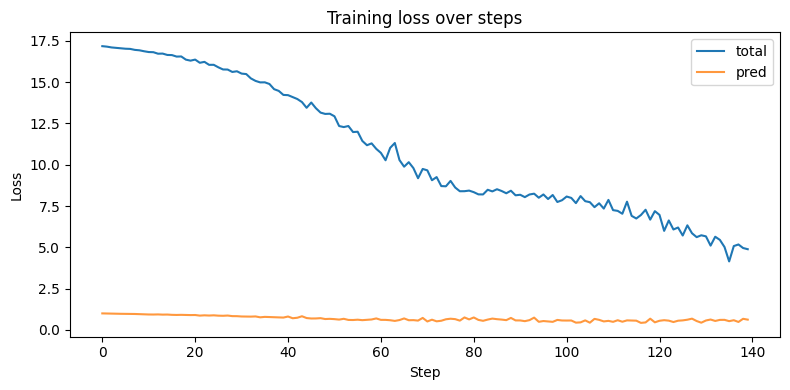

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot([l["total"] for l in losses], label="total")
ax.plot([l["pred"] for l in losses], label="pred", alpha=0.8)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Training loss over steps")
plt.tight_layout()
plt.savefig(out_dir / "training_loss.png", dpi=100)
plt.show()

In [7]:
first_avg = sum(l["total"] for l in losses[:10]) / min(10, len(losses))
last_avg = sum(l["total"] for l in losses[-10:]) / min(10, len(losses))
has_nan = any(not (l["total"] == l["total"]) for l in losses)  # nan != nan
decreased = last_avg < first_avg
print(f"First 10 steps avg loss: {first_avg:.4f}")
print(f"Last 10 steps avg loss:  {last_avg:.4f}")
print(f"Loss decreased: {decreased} {'✓' if decreased else '✗'}")
if has_nan:
    raise AssertionError("Training failed: NaN in losses. Check data and model (try float32, gradient clipping).")
assert decreased, "Training failed: loss did not decrease"

First 10 steps avg loss: 17.0347
Last 10 steps avg loss:  5.1098
Loss decreased: True ✓


In [8]:
x_infer, _, _, _, _ = next(iter(loader))
x_infer = x_infer.permute(0, 2, 1, 3, 4).to(device)
with torch.no_grad():
    z = jepa.encode(x_infer)
print("Encoded shape:", z.shape)

Encoded shape: torch.Size([64, 2, 17, 1, 1])


## 2D embedding interpretability

**Why trajectories lie on y=-x**: With `use_final_ln=True`, TimeSeriesEncoder applies LayerNorm on the 2D output. LayerNorm forces mean=0 across features per sample, so dim0+dim1=0 → dim1=-dim0. The effective representation is 1D. We use `use_final_ln=False` here so embeddings can span 2D and potentially capture bullish/bearish vs volatility.

**Goal**: Check if the model learned to separate bullish vs bearish (net dPrice direction) and volatile vs calm (leverage effects).

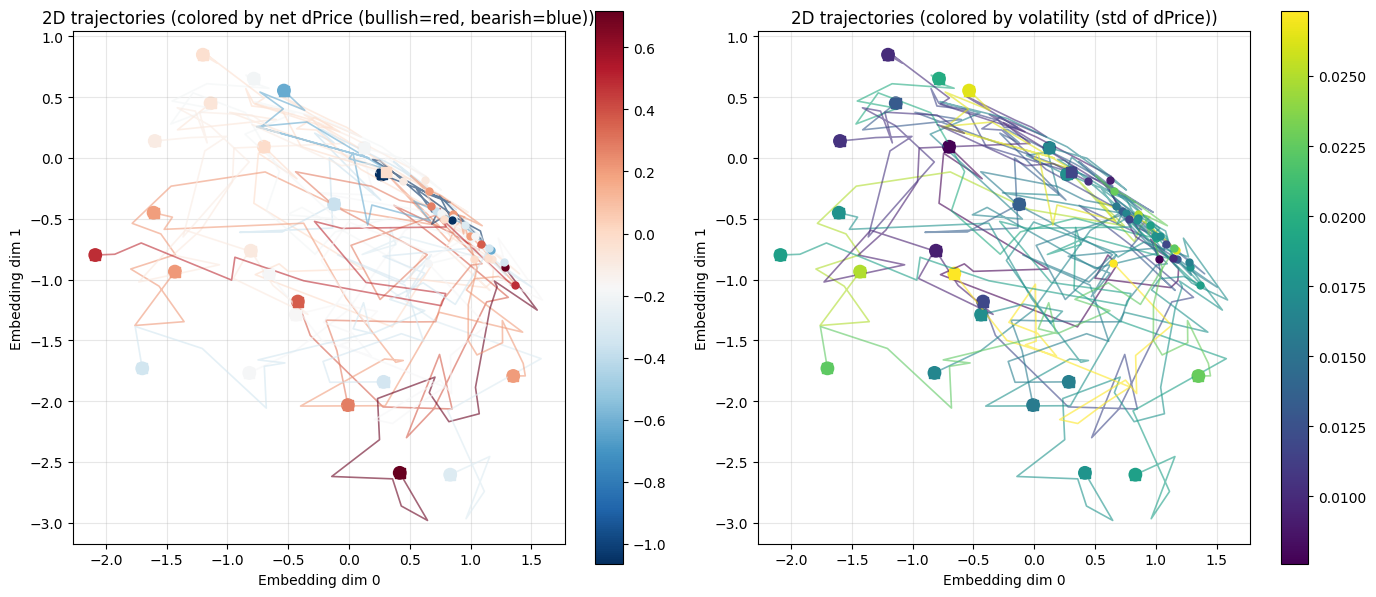

Correlation dim0 vs dim1: -0.3505 (if ~-1, LayerNorm forces y=-x)


In [9]:
# goal: see if embeddings capture dPrice direction (bullish/bearish) and volatility (leverage effects)
jepa.eval()
all_z, all_loc = [], []
with torch.no_grad():
    for i, (x_b, _, loc_b, _, _) in enumerate(loader):
        if i >= 32:
            break
        x_b = x_b.permute(0, 2, 1, 3, 4).to(device)
        x_b = torch.nan_to_num(x_b, nan=0.0, posinf=0.0, neginf=0.0)
        z_b = jepa.encode(x_b)
        all_z.append(z_b.cpu())
        all_loc.append(loc_b)
z_all = torch.cat(all_z, dim=0)
loc_all = torch.cat(all_loc, dim=0)
z_2d = z_all[:, :, :, 0, 0].permute(0, 2, 1)
# loc: [B,T,8] with dPrice=loc[:,:,0], volume=loc[:,:,1], spread=loc[:,:,2]
dprice = loc_all[:, :, 0]
dprice_cumsum = dprice.cumsum(dim=1)
bullish_bearish = (dprice_cumsum[:, -1] - dprice_cumsum[:, 0]).numpy()
volatility = dprice.std(dim=1).numpy()
n_traj = min(24, z_2d.shape[0])
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax_idx, (color_by, cmap_name, title_suffix) in enumerate([
    (bullish_bearish, "RdBu_r", "colored by net dPrice (bullish=red, bearish=blue)"),
    (volatility, "viridis", "colored by volatility (std of dPrice)"),
]):
    ax = axes[ax_idx]
    sc = ax.scatter(z_2d[:n_traj, -1, 0].numpy(), z_2d[:n_traj, -1, 1].numpy(), c=color_by[:n_traj], cmap=cmap_name, s=80)
    plt.colorbar(sc, ax=ax)
    for i in range(n_traj):
        zt = z_2d[i].numpy()
        vmin, vmax = color_by[:n_traj].min(), color_by[:n_traj].max()
        norm_val = (color_by[i] - vmin) / (vmax - vmin + 1e-8)
        c = plt.get_cmap(cmap_name)(norm_val)
        ax.plot(zt[:, 0], zt[:, 1], alpha=0.6, color=c, linewidth=1.2)
        ax.scatter(zt[0, 0], zt[0, 1], s=25, color=c, marker="o", zorder=5)
        ax.scatter(zt[-1, 0], zt[-1, 1], s=45, color=c, marker="s", zorder=5)
    ax.set_xlabel("Embedding dim 0")
    ax.set_ylabel("Embedding dim 1")
    ax.set_title(f"2D trajectories ({title_suffix})")
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out_dir / "trajectories_2d.png", dpi=120)
plt.show()
# diagnostic: correlation dim0 vs dim1 (if use_final_ln=True, expect ~-1)
z_flat = z_2d[:n_traj].reshape(-1, 2).numpy()
corr = np.corrcoef(z_flat[:, 0], z_flat[:, 1])[0, 1]
print(f"Correlation dim0 vs dim1: {corr:.4f} (if ~-1, LayerNorm forces y=-x)")

## Embedding correlation diagnostics

**Why embeddings can be correlated**: JEPA learns representations for prediction, not decorrelation. Some correlation is normal. **Concerning**: off-diagonal correlation near ±1 (dimensional collapse) or many near-zero eigenvalues (representation collapse).

**What helps**: Lower reg (cov, std, sim_t), `use_final_ln=False`, `pred_coeff`>1, `CosineLossSeq`.

In [ ]:
# embedding correlation diagnostics: check for dimensional collapse
# high off-diagonal correlation = collapse; many near-zero eigenvalues = collapse
z_flat_all = z_2d.reshape(-1, 2).numpy()
corr_mat = np.corrcoef(z_flat_all.T)
eigvals = np.linalg.eigvalsh(np.cov(z_flat_all.T))
eigvals = np.sort(eigvals)[::-1]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im = axes[0].imshow(corr_mat, cmap="RdBu_r", vmin=-1, vmax=1)
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(["dim0", "dim1"])
axes[0].set_yticklabels(["dim0", "dim1"])
axes[0].set_title("Embedding correlation matrix")
plt.colorbar(im, ax=axes[0])
axes[1].bar(range(len(eigvals)), eigvals, color="steelblue")
axes[1].set_xlabel("Eigenvalue index")
axes[1].set_ylabel("Eigenvalue")
axes[1].set_title("Covariance eigenvalue spectrum")
axes[1].axhline(y=0.1, color="gray", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(out_dir / "embedding_correlation.png", dpi=100)
plt.show()
# interpretation: off-diag abs(corr)>>0.5 suggests collapse; eigvals[1]/eigvals[0]<<1 suggests 1D effective
print(f"Correlation dim0 vs dim1: {corr_mat[0,1]:.4f}")
ratio = eigvals[1] / (eigvals[0] + 1e-10)
print(f"Eigenvalue ratio (small/large): {ratio:.4f} (if <<1, effective 1D)")

## Summary

- **Data**: HFT state (dPrice, volume, spread) + action (imbalance)
- **Model**: TimeSeriesEncoder + RNNPredictor + VC_IDM_Sim_Regularizer
- **Full train**: `uv run python -m examples.ac_timeseries_jepa.main`